In [1]:
import pdb
import random
import numpy as np
import pandas as pd
import seaborn as sns
from inspect import signature
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Data preprossessing

In [2]:
trainset=pd.read_table('drugLib_raw/drugLibTrain_raw.tsv',sep='\t')
testset=pd.read_table('drugLib_raw/drugLibTest_raw.tsv',sep='\t')    
dataset=pd.concat([trainset,testset], axis=0)
classes=np.unique(dataset['rating'])
dataset.describe()

,Unnamed: 0,rating
count,4143.000000,4143.000000
mean,2081.808834,6.946416
std,1202.018138,2.948868
min,0.000000,1.000000
25%,1041.500000,5.000000
50%,2083.000000,8.000000
75%,3123.500000,9.000000
max,4161.000000,10.000000


(array([420., 136., 195., 151., 226., 215., 471., 748., 613., 968.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

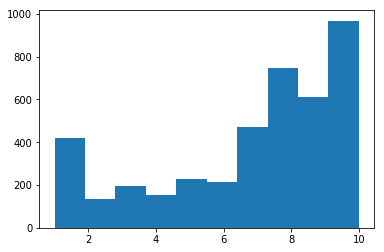

In [3]:
plt.hist(dataset['rating'])

In [4]:
print('Existing classes in our target variable=====', np.unique(dataset['rating']))
print('Number of classes of our target variable=====',len(np.unique(dataset['rating'])))

Existing classes in our target variable===== [ 1  2  3  4  5  6  7  8  9 10]
Number of classes of our target variable===== 10


In [5]:
tf_df = dataset.isnull()


In [6]:
dataset.columns

Index(['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects',
       'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'],
      dtype='object')

Text(0, 0.5, 'count')

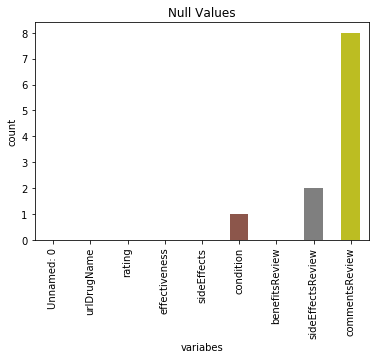

In [7]:
dataset.isnull().sum().plot(kind='bar')
plt.title('Null Values')
plt.xlabel('variabes')
plt.ylabel('count')

When we look at the number of null values, we realise that 
they are few compart to the size of the data. From here decided to delete them.

In [8]:
dataset = dataset.dropna()
dataset.shape

(4132, 9)

In [9]:
dataset['rating'] = dataset['rating'].apply(lambda x : x-1)
target=dataset['rating'].values


In [10]:
from nltk.corpus import stopwords
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=20,max_features=20,
                        ngram_range=(1, 2), 
                        stop_words='english')

features1 = tfidf.fit_transform(dataset['sideEffects']).toarray()
features2 = tfidf.fit_transform(dataset['commentsReview']).toarray()
features3 = tfidf.fit_transform(dataset['benefitsReview']).toarray()
features4 = tfidf.fit_transform(dataset['effectiveness']).toarray()
features5= tfidf.fit_transform(dataset['sideEffectsReview']).toarray()
features6= tfidf.fit_transform(dataset['condition']).toarray()
data_text=np.concatenate([features1,features3, features2,features4 ,features5,features6],axis=1)

In the flowing lines, we split the initial data set in fours different data sets(10%,30%,60% and 100%).

In [11]:

classes=np.unique(target)
size_10=int(0.1 * len(dataset))
dataset1=data_text[:size_10,:]
target1=target[:size_10]

size_30=int(.3 * len(dataset))
dataset2=data_text[:size_30,:]
target2=target[:size_30]


size_60=int(.6 * len(dataset))
dataset3=data_text[:size_60,:]
target3=target[:size_60]

dataset4=data_text
target4=target

## Softmax logistic regression

In [12]:
class logistiSoft():
    def __init__(self, feature, target,classes,lr=0.1, epoch=1000):
        self.feature=feature
        self.cl=len(classes)
        self.target=np.eye(len(classes))[target.astype(int).flatten()]
        #print(target)
        self.w = np.zeros([self.feature.shape[1],self.cl])
        self.epoch=epoch
        self.lr=lr
        self.m = feature.shape[0]
        
    def softmax(self,z):
        z -= np.max(z)
        z= np.add(z,1)
        sm = (np.exp(z).T /(np.nansum(np.exp(z),axis=1))).T
        return sm
    
    def getProbsAndPreds(self, x):
        probs = self.softmax(np.dot(x,self.w))
        preds = np.argmax(probs,axis=1)
        return probs,preds
    def gradient(self,x,y):
        proba,pred=self.getProbsAndPreds(x)
        #print(proba.shape)
        grad=(-1/self.m)*np.dot(x.T,(proba-y))
        return grad
    def cost_function(x, y):
        p = self.softmax(np.dot(x,self.w))
        return -y *np.log(p)

    def fitfunction(self):
        costs=[]
        for i in range(0,self.epoch):
            grad = self.gradient(self.feature,self.target)
            self.w +=(self.lr * grad)  
        costs.append(self.softmax(np.dot(self.feature,self.w)))

        return  costs
    def prediction(self,x_tes,y_tes):
        prob,prede = self.getProbsAndPreds(x_tes)
        accuracy = accuracy_score(np.array(prede) .reshape(-1,1),y_tes)
        print('accuracy', '======',accuracy)
        return prede,accuracy


## Gaussian discriminant analysis

In [13]:
class MultiGDA():
    def mu(self,x,y):
        classes=list(np.unique(y))
        m=[]
        for c in classes:
            a=list(np.mean([x[i] for i in range(len(y)) if y[i]==c], axis=0))
            m.append(a)
            
        return m
    def phy(self,y,classes):
        pi=[]
        for i in classes:
            pi.append(1/(len(y))*np.sum(y==i))
        return  pi
    def sigma(self,x,y, classes):
        n=len(y)
        sigma=np.zeros([len(x[0]),len(x[0])])
        for i in range(n):
            cov=[]
            xi=x[i:]
            yi=y[i]
            for j in range(len(classes)):
                cov.append(np.dot((xi-self.mu(x,y)[j]).T,(xi-self.mu(x,y)[j])))
            for c in range(len(classes)):
                if yi==classes[c]:
                    covv=cov[c]
                    sigma=sigma+covv
            sigma=sigma/n
            return sigma
    def multinormal(self,x,mop,sigmacov,pi,classes):
        n=len(x)
        predicts=[]
        for i in range(len(classes)):
            dif1=(x-mop[i]).reshape(1,-1)
            pred1=np.exp((-1/2)*np.dot(np.dot(dif1,np.linalg.pinv(sigmacov)),dif1.T))*pi[i]
            pred2=pred1[0][0]
            predicts.append(pred2)
        return predicts
    def fit(self,x,y,classes):
        mu=self.mu(x,y)
        pi=self.phy(y,classes)
        sigmacov=self.sigma(x,y, classes)
        return classes, mu,pi,sigmacov
    def predictions(self,x,y,classes, m, pi,sig_op):
        pred=[]
        for i in range(len(x)):
            k=x[i].reshape(1,-1)
            preds=self.multinormal(k,m,sigmacov,pi,classes)
            pred.append(np.argmax(preds))
        acc=np.sum(pred==y)/len(y)
        print('Accuracy=====',acc)

        return pred,acc


## Naive bayes

In [14]:
class NaiveBayes():
    def __init__(self,x,y,classes):
        self.x=x
        self.y=y
        self.classes=classes
        self.all_means = self.meanns()
        self.all_sig = self.sigmas(self.all_means)
        self.all_priors = self.priors()
    def meanns(self):
        lists = []
        mu=[]
        for c in self.classes:
            for i in range(len(self.y)):
                if self.y[i]==c:
                    lists.append(self.x[i])
            mu.append(np.sum(np.array(lists))/len(self.y))
        return mu
    def sigmas(self,mu):
            sigma=np.zeros((self.x.shape[1],self.x.shape[1]))
            lists=[]
            for c in self.classes:
                for i in range(len(self.y)):
                    if self.y[i]==c:
                        lists.append(np.array(self.x[i]))
                dif =np.array(lists)- np.array(mu[c])
                sigma += np.dot( dif.T,dif)
            return sigma/len(self.y)
    def priors(self):
        prior={}
        for clas in classes:
            prior[clas]=len(self.x[self.y==clas])/len(self.y)
        return prior
    def fit_distribution(self,x):
        lists=[]
        distrib=[]
        for c in self.classes:  
            deno=1/(((2*np.pi)**((len(self.classes))/2))*(((np.linalg.det(self.all_sig))+0.1)**1/2))
            dif=x - np.array(self.all_means[c])
            distrib.append(self.all_priors[c]*deno*np.exp(-(1/2)*np.dot(np.dot(dif,np.linalg.pinv(self.all_sig)),dif.T)))
        return np.array(distrib)
    
    def predic(self,x_test,y_test):    
        prob=[]
        pred=[]
        for i in x_test:
            prob=np.argmax(self.fit_distribution(i))
            pred.append(prob)
        acc=np.sum(pred==y_test)/len(y_test)
        print('Accuracy=====',acc)
        return pred,acc
            

In [15]:
def precision(ytest,predictGDA,predictlogist,predictnaiv):
    prec_GDA=precision_score(predictGDA,ytest,average='weighted')
    prec_LOG=precision_score(predictlogist,ytest,average='weighted')
    prec_NV=precision_score(predictnaiv,ytest,average='weighted')
    compart=pd.DataFrame([['GDA',prec_GDA],['LOG',prec_LOG],['Naiv',prec_NV]])
    compart.columns = ['Model','precision']

    return compart
    

The objective of this project is to compare GDA and Naive bayes with logistique reression.

# comparaison with 10% of the data set

In [16]:
size=int(.8 * len(dataset1))
X_train1= dataset1[:size, :]
Y_train1= target1[:size]
X_test1=dataset1[size:,:]
Y_test1=target1[size:]

#### logistic

In [17]:
p=logistiSoft(X_train1,Y_train1,classes)
p.fitfunction()
pedictLogist1,accL1=p.prediction(X_test1,Y_test1)

accuracy ====== 0.39759036144578314


#### GDA

In [18]:
p=MultiGDA()
classes=list(np.unique(Y_train1))
c,mu,pi,sigmacov=p.fit(X_train1,Y_train1,classes)
sigmacovnew=sigmacov+(0.3*np.identity(sigmacov.shape[0]))
predictionGDA1,accG1=p.predictions(X_test1,Y_test1,classes, mu,pi, sigmacovnew)
#np.sum(predictionGDA1==Y_test1)/len(Y_test1)


Accuracy===== 0.3253012048192771


### Naive bayes

In [19]:
p=NaiveBayes(X_train1,Y_train1,classes)
preditnv1,accn1=p.predic(X_test1,Y_test1)



Accuracy===== 0.27710843373493976


In the flowing line, we compart the average precision of the tree models

In [20]:
preci_10=precision(Y_test1,predictionGDA1,pedictLogist1,preditnv1)
preci_10['accuracy']=[accG1,accL1,accn1]
preci_10

,Model,precision,accuracy
0,GDA,0.395748,0.325301
1,LOG,0.550445,0.397590
2,Naiv,0.741824,0.277108


Using 10% of the data, we observe that the naive bayes has the highest precision (0.74) flowed by logistice regression(0.55). The logistic regression give us  the highest accuracy(39%) flowed by GDA(32%).

## comparaison with 30% of the data set

In [21]:
size2=int(.8 * len(dataset2))
X_train2= dataset2[:size2, :]
Y_train2= target2[:size2]
X_test2=dataset2[size2:,:]
Y_test2=target2[size2:]

In [22]:
print(dataset2.shape,target2.shape)

(1239, 99) (1239,)


### Logistic

In [1368]:
p=logistiSoft(X_train2,Y_train2,classes)
p.fitfunction()
predictLogist2,accL2=p.prediction(X_test2,Y_test2)

accuracy ====== 0.4435483870967742


### GDA

In [1369]:
p=MultiGDA()
c,mu,pi,sigmacov=p.fit(X_train2,Y_train2,classes)
sigmacovnew=sigmacov+(0.3*np.identity(sigmacov.shape[0]))
predictionGDA2,accG2=p.predictions(X_test2,Y_test2,classes, mu,pi, sigmacovnew)

Accuracy===== 0.3951612903225806


In [1370]:
p=NaiveBayes(X_train2,Y_train2,classes)
preditnv2,accn2=p.predic(X_test2,Y_test2)


Accuracy===== 0.25


In [1371]:
preci_30=precision(Y_test2,predictionGDA2,predictLogist2,preditnv2)
preci_30['accuracy']=[accG2,accL2,accn2]
preci_30

,Model,precision,accuracy
0,GDA,0.487173,0.395161
1,LOG,0.666810,0.443548
2,Naiv,0.727706,0.250000


Using 30% of the data, we observe that the Naive bayes has the best precision(0.72) flowed by the logistic regression(0.66) which has also the best accuracy(44.3%).

# comparaison with 60% of the data set

In [1372]:
size2=int(.8 * len(dataset3))
X_train3= dataset3[:size2, :]
Y_train3= target3[:size2]
X_test3=dataset3[size2:,:]
Y_test3=target3[size2:]

### Logistic

In [1373]:
p=logistiSoft(X_train3,Y_train3,classes)
p.fitfunction()
predictLogist3,accL3=p.prediction(X_test3,Y_test3)

accuracy ====== 0.47580645161290325


### GDA

In [1374]:
p=MultiGDA()
classes=list(np.unique(Y_train3))
c,mu,pi,sigmacov=p.fit(X_train3,Y_train3,classes)
sigmacovnew=sigmacov+(0.3*np.identity(sigmacov.shape[0]))
predictionGDA3,accG3=p.predictions(X_test3,Y_test3,classes, mu,pi, sigmacovnew)


Accuracy===== 0.4153225806451613


In [1375]:
p=NaiveBayes(X_train3,Y_train3,classes)
preditnv3,accn3=p.predic(X_test3,Y_test3)


Accuracy===== 0.22983870967741934


In [1376]:
preci_60=precision(Y_test3,predictionGDA3,predictLogist3,preditnv3)
preci_60['accuracy']=[accG3,accL3,accn3]
preci_60

,Model,precision,accuracy
0,GDA,0.518232,0.415323
1,LOG,0.696049,0.475806
2,Naiv,0.753345,0.229839


With 60% of the data,  logistic regression still has the best accuracy(0.47). But when we look at the precision, we realise that naive bayes has the best precision(0.75). We can also see that the accuracy of GDA is increasing.While the performance of naive bayes is decreasing.

# comparaison with 100% of the data set

In [1377]:
size=int(0.8 * len(dataset4))
X_train4= dataset4[:size, :]
Y_train4= target4[:size]
X_test4=dataset4[size:,:]
Y_test4=target[size:]


### Logistic

In [1378]:
p=logistiSoft(X_train4,Y_train4,classes)
p.fitfunction()
predictLogist4,accL4=p.prediction(X_test4,Y_test4)

accuracy ====== 0.4570737605804111


### GDA

In [1379]:
p=MultiGDA()
c,mu,pi,sigmacov=p.fit(X_train4,Y_train4,classes)
sigmacovnew=sigmacov+(0.3*np.identity(sigmacov.shape[0]))
predictGDA4,accG4=p.predictions(X_test4,Y_test4,classes, mu,pi, sigmacovnew)


Accuracy===== 0.437726723095526


### Naive bayes

In [1380]:
p=NaiveBayes(X_train4,Y_train4,classes)
preditnv4,accn4=p.predic(X_test4,Y_test4)

Accuracy===== 0.22974607013301088


In [1381]:
preci_100=precision(Y_test4,np.array(predictGDA4),predictLogist4,preditnv4)
preci_100['accuracy']=[accG4,accL4,accn4]
preci_100

,Model,precision,accuracy
0,GDA,0.543849,0.437727
1,LOG,0.678056,0.457074
2,Naiv,0.715353,0.229746


For 100% of the data set, the logistic regression still has the best accuracy(45%) while decreasing. At the same time the accuracy and precision of the Naive bayes continu decreasing but it still has the best precision compare to logistic and GDA.

## General conclusion

In [1382]:
precis=pd.concat([preci_10,preci_30,preci_60,preci_100])
precis['size']=[0.1,0.1,0.1,0.3,0.3,0.3,0.6,0.6,0.6,1,1,1]
precis


,Model,precision,accuracy,size
0,GDA,0.395748,0.325301,0.1
1,LOG,0.550445,0.397590,0.1
2,Naiv,0.741824,0.277108,0.1
0,GDA,0.487173,0.395161,0.3
1,LOG,0.666810,0.443548,0.3
2,Naiv,0.727706,0.250000,0.3
0,GDA,0.518232,0.415323,0.6
1,LOG,0.696049,0.475806,0.6
2,Naiv,0.753345,0.229839,0.6
0,GDA,0.543849,0.437727,1.0


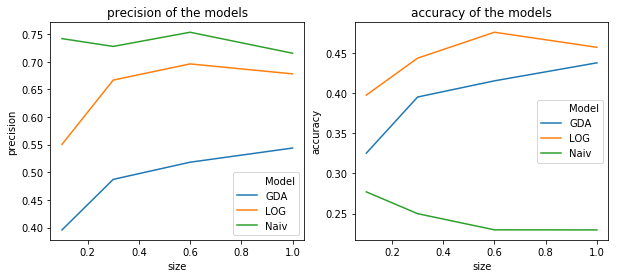

In [1383]:
f, axes = plt.subplots(1, 2,figsize=(10,4))
sns.lineplot('size','precision',hue='Model', data=precis,ax=axes[0])
axes[0].set_title('precision of the models')
sns.lineplot('size','accuracy',hue='Model', data=precis,ax=axes[1])
axes[1].set_title('accuracy of the models')


plt.show()

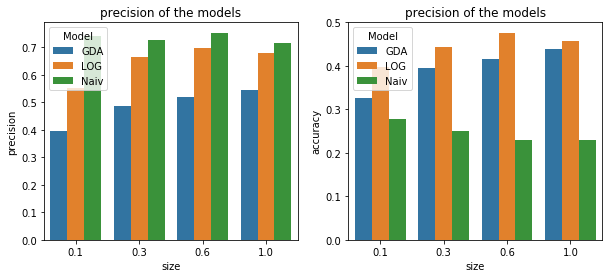

In [1384]:
f, axes = plt.subplots(1, 2,figsize=(10,4))
sns.barplot('size','precision',hue='Model', data=precis,ax=axes[0])
axes[0].set_title('precision of the models')

sns.barplot('size','accuracy',hue='Model', data=precis,ax=axes[1])
axes[1].set_title('precision of the models')

plt.show()

IN the graphs above, we visualize the precision and the accuracy according to the size of the data set. We oserve tha the performance of GDA increases between 0 to 30% of the data and it decrease a bit before it continue increasing. For the logistic regression, the performance increase and start decreasing when the size of the data is big. But for naive base, the accuracy and the precision decreases when the data increases.

In general, if we look at the limites of our curves, we realize that when the data is to small,the naive bayes perform better than logistic and when the data is to big(goes to infinity), we observe that GDA perform better than logistic.